<a href="https://colab.research.google.com/github/nisaodabas/CNG483-Project2/blob/master/CNG483_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.models import load_model  
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from google.colab import output
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def createDataSet(path):
    df = pd.read_csv(path, sep='\n')
    data = np.array(df)

    #print(data)
    numAttr = 0
    rows = []
    for row in data:        
        found = row[0].find("@ATTRIBUTE")
        if(found != -1):
            numAttr += 1
        else:
            # ignore @ATTRIBUTE rows
            rows.append(row[0].split(","))

    # delete @DATA row
    rows = np.array(rows[1:])
    
    labels = rows[:, -1].astype('int')
    features = rows[:, :numAttr-1].astype('int')
    labels = np.array([x - 1 for x in labels])
    '''
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(labels)
    encoded_Y = encoder.transform(labels)
    # convert integers to dummy variables (i.e. one hot encoded)
    labels = np_utils.to_categorical(encoded_Y)
    print(labels)
    '''
    return features, labels

In [0]:
def model(X, y, dim):

    # define model
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

    model = Sequential()
    model.add(Dense(12, activation='relu', kernel_initializer='he_normal', input_dim=dim))
    model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    # compile the model
    opt = RMSprop(learning_rate=0.00001)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    '''
        # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4000, verbose=0, callbacks=[es, mc])

    # list all data in history
    print(history.history.keys())

    # load the saved model
    saved_model = load_model('best_model.h5')
    # evaluate the model
    _, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = saved_model.evaluate(X_val, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    '''
    numEpochs = 3000
    history = model.fit(X_train, y_train, epochs=numEpochs, batch_size=128, validation_data=(X_val, y_val))
    print(history.history.keys())
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1,numEpochs+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc_train = history.history['acc']
    acc_val = history.history['val_acc']
    epochs = range(1,numEpochs+1)
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    #return model

In [0]:
if __name__ == "__main__":
    geometic_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TestingSet.txt"
    geometic_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TrainingSet.txt"

    texture_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TestingSet.txt"
    texture_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TrainingSet.txt"


    #geo_x_train, geo_y_train = createDataSet(geometic_train_path)
    #geo_x_test, geo_y_test = createDataSet(geometic_test_path)

    txtr_x_train, txtr_y_train = createDataSet(texture_train_path)
    txtr_x_test, txtr_y_test = createDataSet(texture_test_path)


Streaming output truncated to the last 5000 lines.
Epoch 502/3000
8/8 [==============================] - 0s 16ms/step - loss: 0.8526 - acc: 0.5366 - val_loss: 0.9127 - val_acc: 0.5721
Epoch 503/3000
8/8 [==============================] - 0s 16ms/step - loss: 0.8644 - acc: 0.5443 - val_loss: 0.9200 - val_acc: 0.5721
Epoch 504/3000
8/8 [==============================] - 0s 16ms/step - loss: 0.8302 - acc: 0.5541 - val_loss: 0.9128 - val_acc: 0.5721
Epoch 505/3000
8/8 [==============================] - 0s 17ms/step - loss: 0.8546 - acc: 0.5421 - val_loss: 0.9136 - val_acc: 0.5721
Epoch 506/3000
8/8 [==============================] - 0s 16ms/step - loss: 0.8517 - acc: 0.5366 - val_loss: 0.9144 - val_acc: 0.5721
Epoch 507/3000
8/8 [==============================] - 0s 16ms/step - loss: 0.8288 - acc: 0.5486 - val_loss: 0.9166 - val_acc: 0.5721
Epoch 508/3000
8/8 [==============================] - 0s 17ms/step - loss: 0.8620 - acc: 0.5399 - val_loss: 0.9170 - val_acc: 0.5721
Epoch 509/3000
8/8

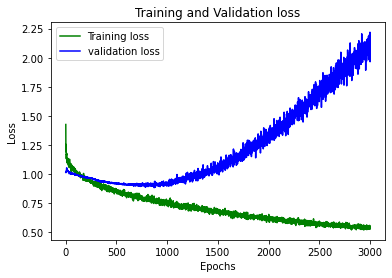

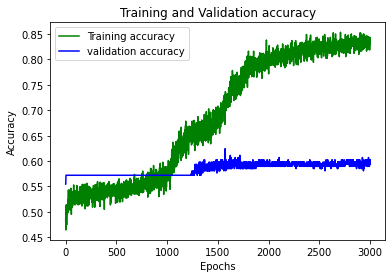

"\n# list all data in history\nprint(history.history.keys())\n# summarize history for accuracy\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n# summarize history for loss\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n"

In [152]:
    model(txtr_x_train, txtr_y_train, 9600)
    '''
    estimator = KerasClassifier(build_fn=model, epochs=2000, batch_size=128, verbose=0)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    results = cross_val_score(estimator, txtr_x_train, txtr_y_train, cv=kfold, scoring='accuracy')

    print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    '''
    '''
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    '''

In [0]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')